# Genertating sample particles using a 2D rejection algorithm #

by: Conor Davidson 22/08/2024

A sample of $N$ particles can be sampled from any continuous two dimensional function using a rejection algorithm. This algorithm is useful for generating particle distributions for particle-in-cell simulations however, it can be applied to any known function. The mathematical idea of the algorithm is outlined here: https://bookdown.org/rdpeng/advstatcomp/rejection-sampling.html. 

To illustrate the idea for one dimensional sampling, we can imagine a sqaure board with a mask that blocks out a portion of the board. If we used a Gaussian function of $x$ as an example, the mask covers the area above the Gaussian function. By throwing darts at the board, representing particles, any that hit the masked portion of the board will be rejected while any that hit the board are accepted. By repeating this process until we have $N$ accepted samples, we have generated a sample from the Gaussian function. The interesting part is that the mask can be any function we choose. The function can also be any number of dimensions although more dimensions adds more complexity and computational time.

To further boost the performance, `numpy` arrays with the advantages of vectorisation are used. I have included the non-vectorised algorithm for completeness but the `rejection_2d_vectorised` function should be used in the first instance.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from rejection_functions import *
#import astropy as ap
from scipy.integrate import quad, dblquad

#plotting parameters
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 400



## Gaussian test ##

The following will show the generation of samples from some test function so that the user can see the algorithm in action. Let us start with a 2D Gaussian functions which has the form:

$$
f(x,y) = A \exp \bigg( -  \bigg( \frac{(x - x_0)^2}{2 \sigma^2_x} + \frac{(y - y_0)^2}{2 \sigma^2_y} \bigg) \bigg)
$$

where $A$ is a constant, $x_0$ is the mean along the $x$ axis, $y_0$ is the mean along the $y$ and $\sigma_{x,y}$ are the standard deviations along the $x$ and $y$ axes. We will now generate samples from this distribution

Max is:  0.006358877042975879
Total number of iterations was 99 
Shape of final generated sample array is  (20000, 2)


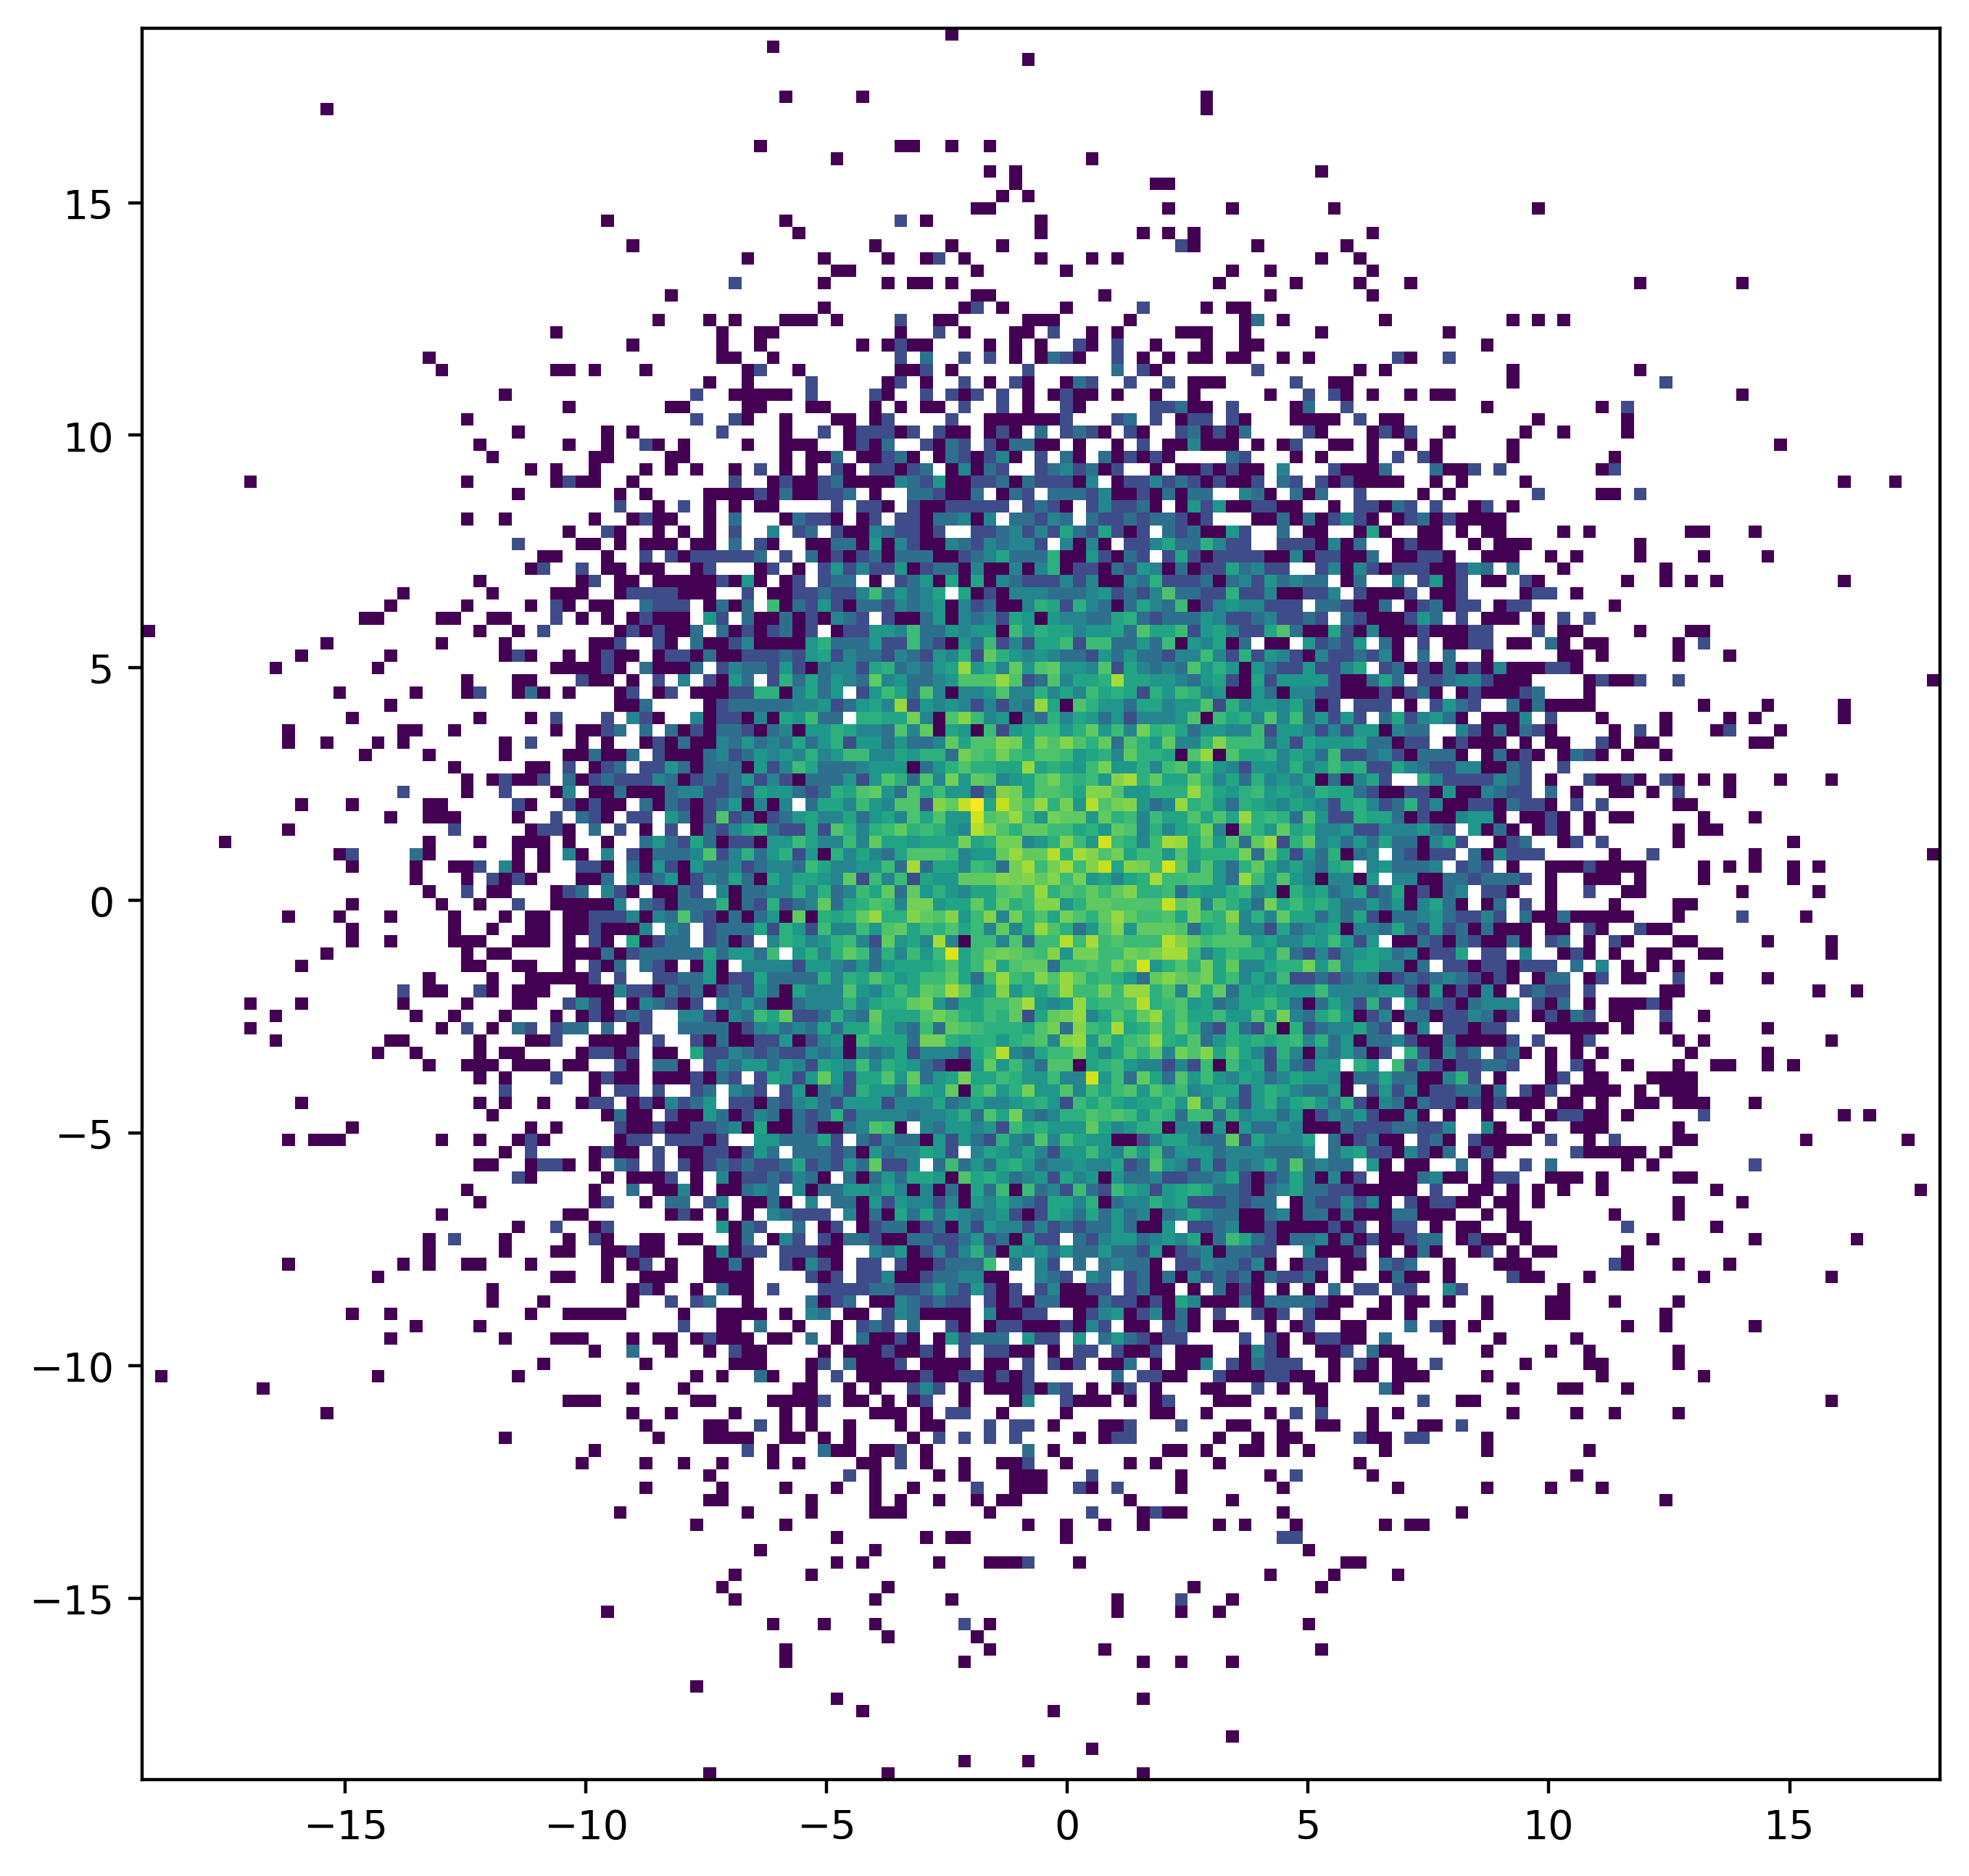

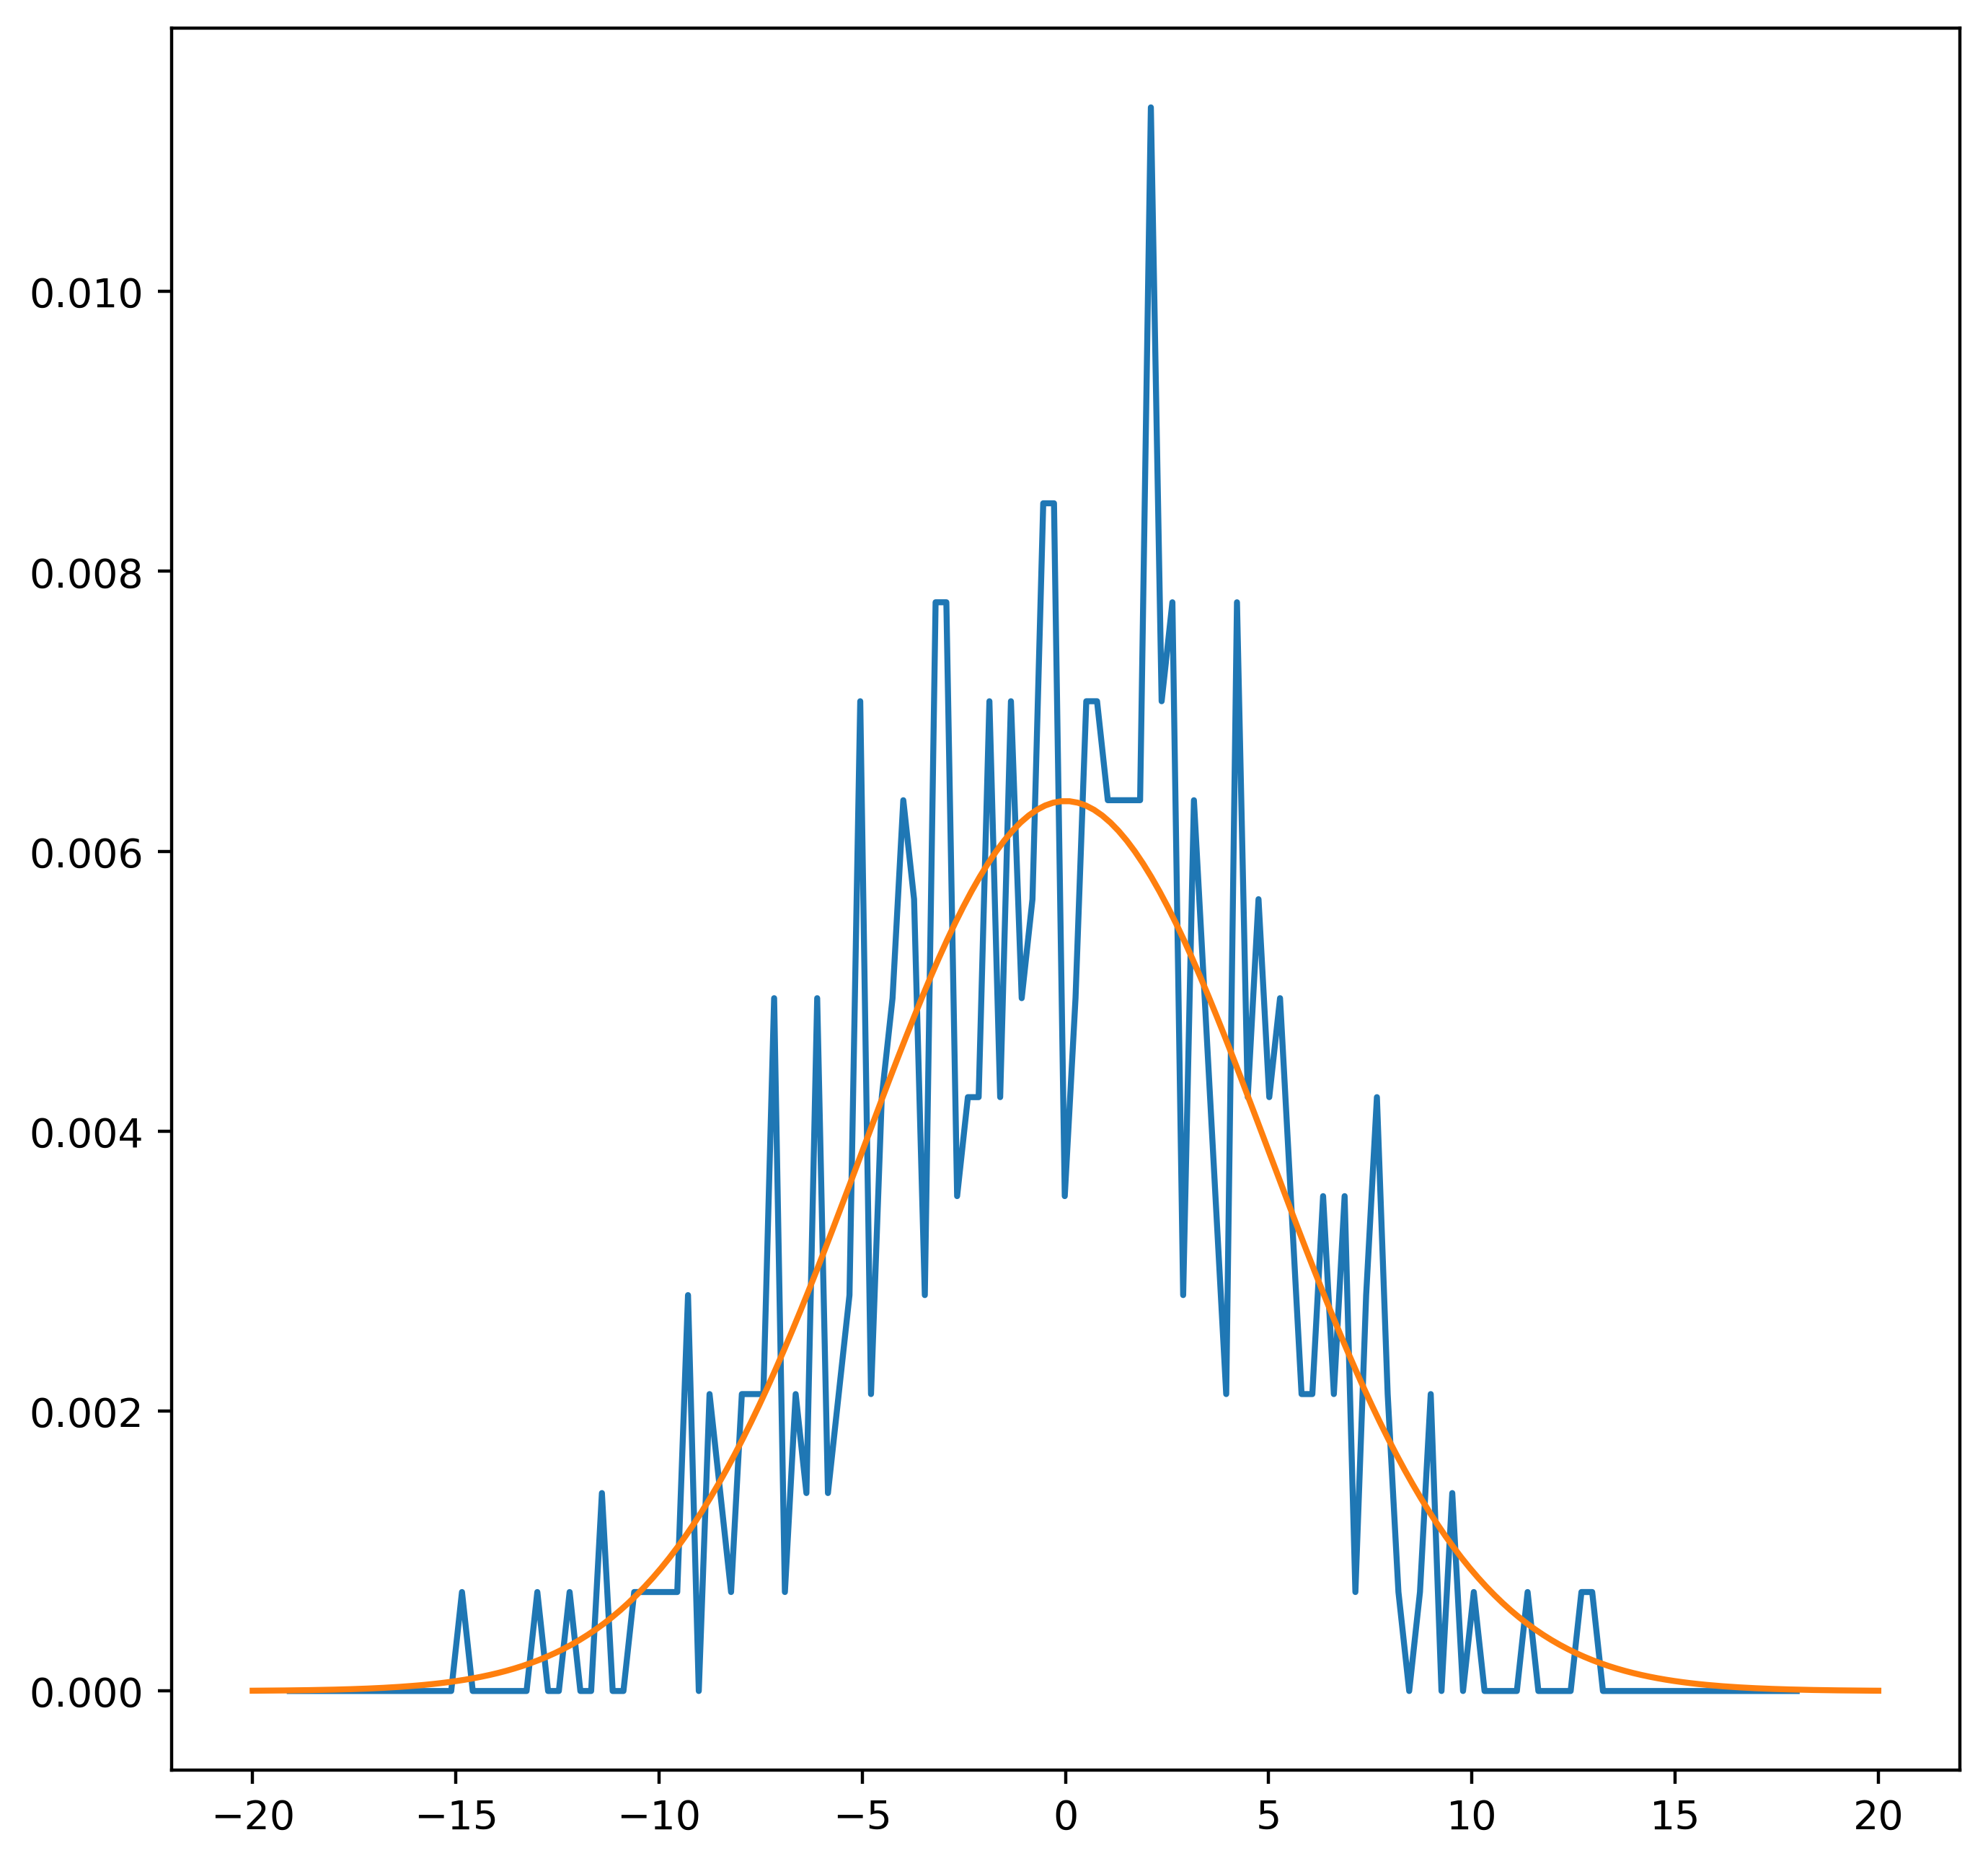

In [4]:
N = 20000 #number of particles
bins_x = int(np.sqrt(N)) #bins for histograms
bins_y = int(np.sqrt(N))
minx = -20.0
Lx = 20.0
miny = -20.0
Ly = 20.0

#simple gaussian for testing
def gaussian(x, y, **kwargs):
    """Simple 1D normalised Gaussian"""
    cst = kwargs["A"]
    xnaught = kwargs["mean_x"]
    ynaught = kwargs["mean_y"]
    sigmax = kwargs["stdev_x"]
    sigmay = kwargs["stdev_y"]
    
    value = cst*np.exp(-1.0*((x - xnaught)**2/(2*sigmax**2) + (y - ynaught)**2/(2.0*sigmay**2)))
    return value

#Generate samples using a constant that normalises the Gaussian function, this simplifies the comparison with histograms
samples = rejection_2d_vectorised(N, minx, Lx, miny, Ly, gaussian, A = 1/157.25795, mean_x = 0.0, mean_y = 0.0, stdev_x = 5.0, stdev_y = 5.0)
xpoints = samples[:,0]
ypoints = samples[:,1]

#2D histogram plot on color logarithm scale
plt.figure()
hist, edges_x, edges_y, img = plt.hist2d(xpoints, ypoints, bins= [bins_x, bins_y], density = True, norm = clr.LogNorm())

#Plot a lines along axis for comparison
plt.figure()
xplotpoints = np.linspace(minx, Lx, 200)
#convert x edges to bin centers
xcentres = (edges_x[:-1] + edges_x[1:])/2.0

#plt.hist(xpoints, bins = bins_x, density = True)
plt.plot(xcentres, hist[:,bins_y//2])
plt.plot(xplotpoints, gaussian(xplotpoints, np.zeros(len(xplotpoints)),  A =  1/157.25795, mean_x = 0.0, mean_y = 0.0, stdev_x = 5.0, stdev_y = 5.0))
plt.show()